In [1]:
# Cell 1: Setup and Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from PIL import Image
import cv2
from pathlib import Path
import os
import glob
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" All packages imported successfully!")

 All packages imported successfully!


In [2]:

def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
def explore_he_dataset(base_path="data/external/data"):
    """
    Explore the H&E dataset structure and catalog all available files
    """
    base_path = Path(base_path)
    
    if not base_path.exists():
        print(f" Path {base_path} does not exist!")
        return None
    
    # Find all ROI folders
    roi_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('ROI')]
    roi_folders.sort()
    
    print(f"📁 Found {len(roi_folders)} ROI folders")
    
    dataset_info = []
    he_files_found = 0
    mask_files_found = 0
    
    for roi_folder in roi_folders:
        he_path = roi_folder / "input" / "he"
        
        if he_path.exists():
            # Find all TIFF files
            all_tiff_files = list(he_path.glob("*.tiff")) + list(he_path.glob("*.tif"))
            
            # Separate H&E images from masks
            he_images = []
            mask_images = []
            
            for tiff_file in all_tiff_files:
                filename_lower = tiff_file.name.lower()
                if "mask" in filename_lower:
                    mask_images.append(tiff_file)
                else:
                    he_images.append(tiff_file)
            
            print(f"  {roi_folder.name}: {len(he_images)} H&E images, {len(mask_images)} masks")
            
            if he_images:
                for he_img in he_images:
                    roi_name = roi_folder.name
                    if "BENIGN" in roi_name.upper():
                        tissue_type = "prostate"
                        cancer_status = "benign"
                    elif "PROSTATE" in roi_name.upper():
                        tissue_type = "prostate"
                        if "TMA" in roi_name.upper():
                            cancer_status = "malignant"
                        else:
                            cancer_status = "unknown"
                    elif "KIDNEY" in roi_name.upper():
                        tissue_type = "kidney"
                        cancer_status = "kidney"
                    elif "LIVER" in roi_name.upper():
                        tissue_type = "liver"
                        cancer_status = "liver"   
                    else:
                        tissue_type = "unknown"
                        cancer_status = "unknown"
                  
                    corresponding_mask = None
                    base_name = he_img.stem  
                    
                    for mask in mask_images:
                        mask_base = mask.stem
                        if (base_name in mask_base or 
                            mask_base.replace("_mask", "").replace("mask", "") == base_name or
                            any(part in mask_base for part in base_name.split("_")[:2])): 
                            corresponding_mask = mask
                            break
                    
                    dataset_info.append({
                        'roi_folder': roi_name,
                        'he_image_path': str(he_img),
                        'mask_path': str(corresponding_mask) if corresponding_mask else None,
                        'tissue_type': tissue_type,
                        'cancer_status': cancer_status,
                        'file_size_mb': he_img.stat().st_size / (1024*1024)
                    })
                    
                    he_files_found += 1
                    if corresponding_mask:
                        mask_files_found += 1
    
    df = pd.DataFrame(dataset_info)
    
    if len(df) > 0:
        print(f"  Total H&E images found: {he_files_found}")
        print(f" Total masks found: {mask_files_found}")
        print(f" Average file size: {df['file_size_mb'].mean():.1f} MB")
        print(f" Tissue types: {df['tissue_type'].value_counts().to_dict()}")
        print(f" Cancer status distribution: {df['cancer_status'].value_counts().to_dict()}")
        
        # Show sample files
        print(f"\n First 5 samples:")
        display(df.head())
        
        return df
    else:
        print("No H&E images found!")
        print("Check if the folder structure matches: ROI*/input/he/*.tiff")
        return None

# Explore the dataset
dataset_df = explore_he_dataset()

📁 Found 63 ROI folders
  ROI009_LIVER_B12: 1 H&E images, 0 masks
  ROI010_PROSTATE_TMA001: 1 H&E images, 1 masks
  ROI011_PROSTATE_TMA002: 1 H&E images, 1 masks
  ROI012_PROSTATE_TMA003: 1 H&E images, 1 masks
  ROI013_PROSTATE_TMA004: 1 H&E images, 1 masks
  ROI014_PROSTATE_TMA005: 1 H&E images, 1 masks
  ROI015_PROSTATE_TMA006: 1 H&E images, 1 masks
  ROI016_PROSTATE_TMA007: 1 H&E images, 1 masks
  ROI017_PROSTATE_TMA008: 1 H&E images, 1 masks
  ROI018_PROSTATE_TMA009: 1 H&E images, 1 masks
  ROI019_PROSTATE_Benign_TMA008N: 1 H&E images, 1 masks
  ROI020_PROSTATE_Benign_TMA011N: 1 H&E images, 1 masks
  ROI021_PROSTATE_TMA012: 1 H&E images, 1 masks
  ROI022_PROSTATE_TMA013: 1 H&E images, 1 masks
  ROI023_PROSTATE_TMA015: 1 H&E images, 1 masks
  ROI024_PROSTATE_TMA016: 1 H&E images, 1 masks
  ROI025_PROSTATE_TMA017: 1 H&E images, 1 masks
  ROI026_PROSTATE_TMA018: 1 H&E images, 1 masks
  ROI027_PROSTATE_TMA019: 1 H&E images, 1 masks
  ROI028_PROSTATE_TMA020: 1 H&E images, 1 masks
  ROI02

roi_folder                                      he_image_path  \
0        ROI009_LIVER_B12  data/external/data/ROI009_LIVER_B12/input/he/R...   
1  ROI010_PROSTATE_TMA001  data/external/data/ROI010_PROSTATE_TMA001/inpu...   
2  ROI011_PROSTATE_TMA002  data/external/data/ROI011_PROSTATE_TMA002/inpu...   
3  ROI012_PROSTATE_TMA003  data/external/data/ROI012_PROSTATE_TMA003/inpu...   
4  ROI013_PROSTATE_TMA004  data/external/data/ROI013_PROSTATE_TMA004/inpu...   

                                           mask_path tissue_type  \
0                                               None       liver   
1  data/external/data/ROI010_PROSTATE_TMA001/inpu...    prostate   
2  data/external/data/ROI011_PROSTATE_TMA002/inpu...    prostate   
3  data/external/data/ROI012_PROSTATE_TMA003/inpu...    prostate   
4  data/external/data/ROI013_PROSTATE_TMA004/inpu...    prostate   

  cancer_status  file_size_mb  
0         liver     21.594986  
1     malignant     22.366226  
2     malignant     21.028091  
3     malignant     20.263443  
4     malignant     19.116470

 Prostate cancer samples:
   • Benign: 5
   • Malignant: 48

 BENIGN samples:
   • ROI019_PROSTATE_Benign_TMA008N
   • ROI020_PROSTATE_Benign_TMA011N
   • ROI051_PROSTATE_Benign_TMA043N

 MALIGNANT samples:
   • ROI010_PROSTATE_TMA001
   • ROI011_PROSTATE_TMA002
   • ROI012_PROSTATE_TMA003


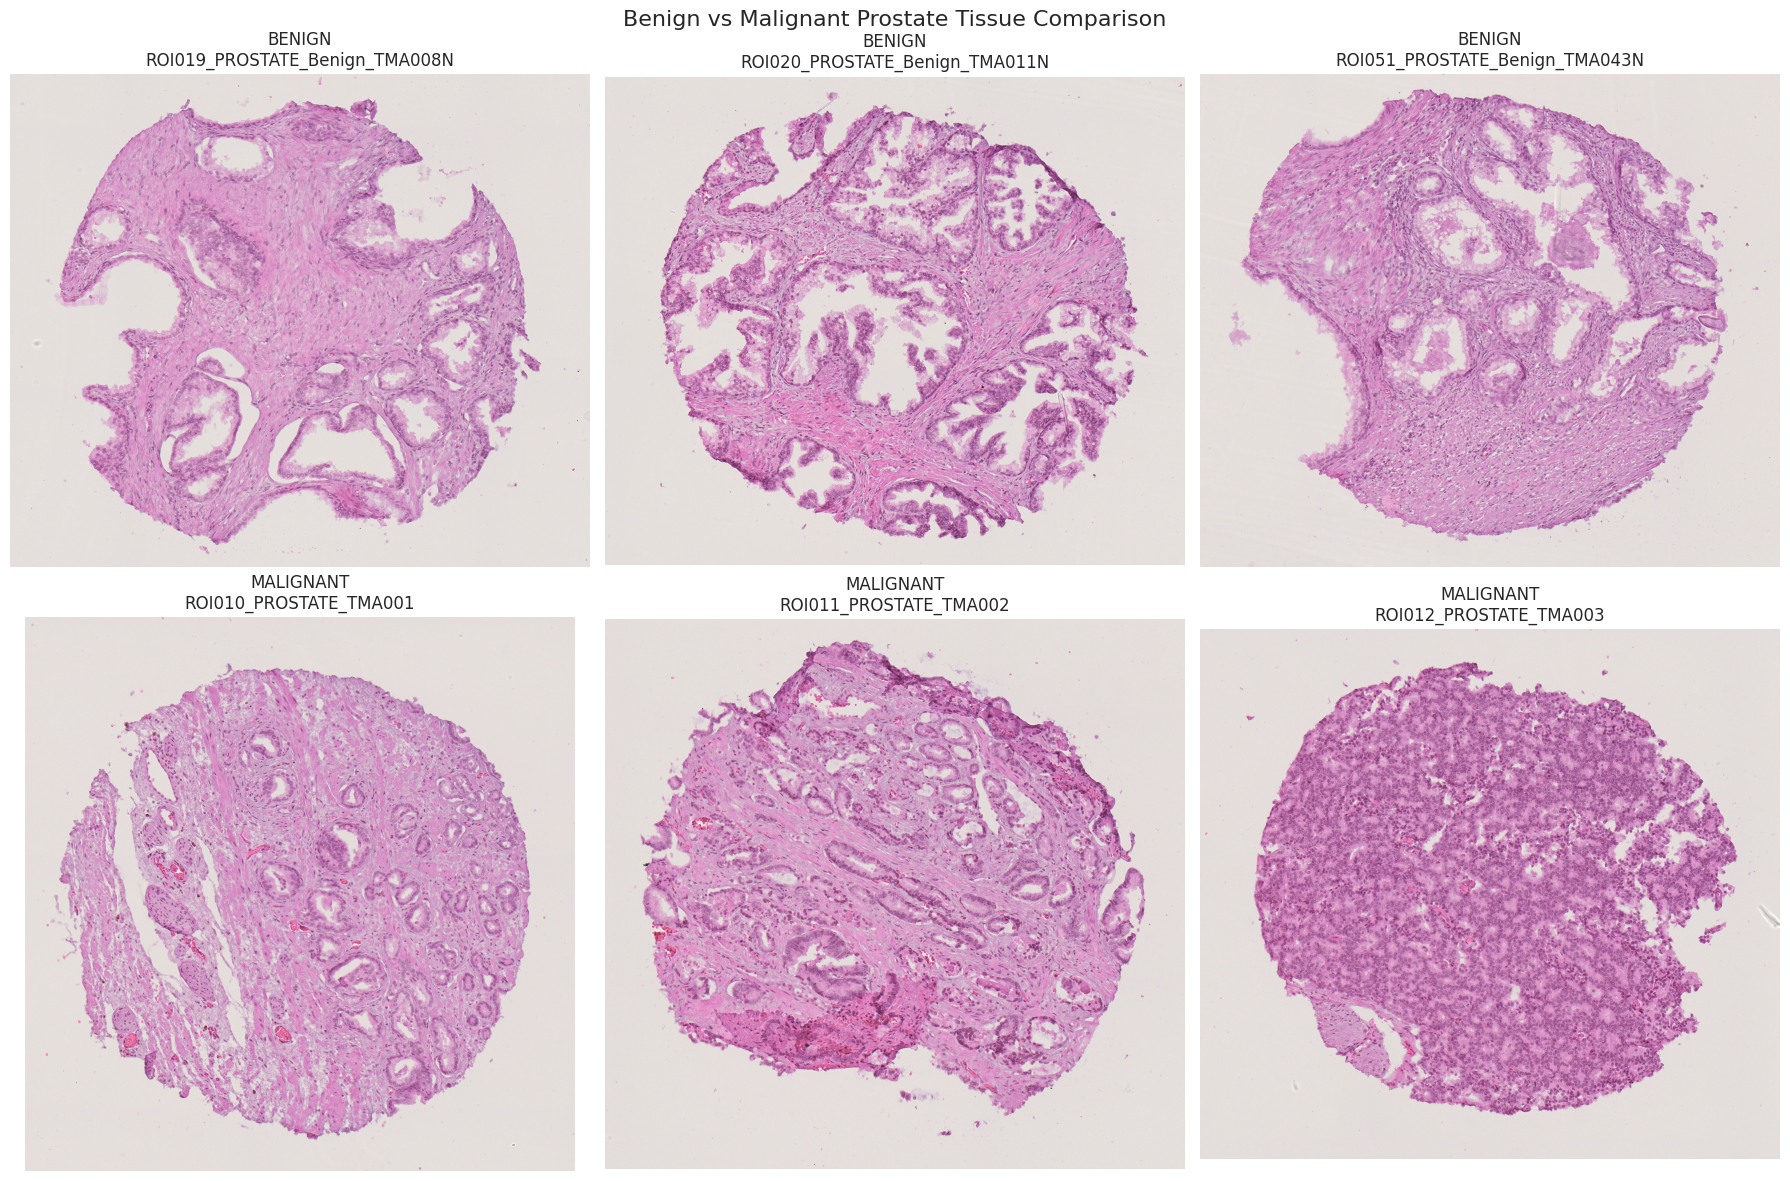

In [4]:
def load_one_image(image_path):
    """
    Load a single H&E image - just the basics!
    """
    try:
        # Open the image file and convert to RGB (standard format)
        image = Image.open(image_path).convert('RGB')
        # Convert to numpy array so we can work with it
        image_array = np.array(image)
        return image_array
    except Exception as e:
        print(f" Couldn't load {image_path}: {e}")
        return None

def show_cancer_status_samples(dataset_df):
    """
    Show samples specifically including benign vs malignant
    """
    
    # Focus on prostate samples with known cancer status
    prostate_df = dataset_df[
        (dataset_df['tissue_type'] == 'prostate') & 
        (dataset_df['cancer_status'].isin(['benign', 'malignant']))
    ]
    
    print(f" Prostate cancer samples:")
    print(f"   • Benign: {len(prostate_df[prostate_df['cancer_status'] == 'benign'])}")
    print(f"   • Malignant: {len(prostate_df[prostate_df['cancer_status'] == 'malignant'])}")
    
    # Get samples of each type
    benign_samples = prostate_df[prostate_df['cancer_status'] == 'benign'].head(3)
    malignant_samples = prostate_df[prostate_df['cancer_status'] == 'malignant'].head(3)
    
    # Create comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Show benign samples
    print(f"\n BENIGN samples:")
    for idx, (_, row) in enumerate(benign_samples.iterrows()):
        if idx < 3:
            img = load_one_image(row['he_image_path'])
            if img is not None:
                axes[0, idx].imshow(img)
                axes[0, idx].set_title(f"BENIGN\n{row['roi_folder']}")
                axes[0, idx].axis('off')
                print(f"   • {row['roi_folder']}")
    
    # Show malignant samples  
    print(f"\n MALIGNANT samples:")
    for idx, (_, row) in enumerate(malignant_samples.iterrows()):
        if idx < 3:
            img = load_one_image(row['he_image_path'])
            if img is not None:
                axes[1, idx].imshow(img)
                axes[1, idx].set_title(f"MALIGNANT\n{row['roi_folder']}")
                axes[1, idx].axis('off')
                print(f"   • {row['roi_folder']}")
    
    plt.suptitle("Benign vs Malignant Prostate Tissue Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the cancer comparison
show_cancer_status_samples(dataset_df)

In [5]:
dataset_df.head()

roi_folder                                      he_image_path  \
0        ROI009_LIVER_B12  data/external/data/ROI009_LIVER_B12/input/he/R...   
1  ROI010_PROSTATE_TMA001  data/external/data/ROI010_PROSTATE_TMA001/inpu...   
2  ROI011_PROSTATE_TMA002  data/external/data/ROI011_PROSTATE_TMA002/inpu...   
3  ROI012_PROSTATE_TMA003  data/external/data/ROI012_PROSTATE_TMA003/inpu...   
4  ROI013_PROSTATE_TMA004  data/external/data/ROI013_PROSTATE_TMA004/inpu...   

                                           mask_path tissue_type  \
0                                               None       liver   
1  data/external/data/ROI010_PROSTATE_TMA001/inpu...    prostate   
2  data/external/data/ROI011_PROSTATE_TMA002/inpu...    prostate   
3  data/external/data/ROI012_PROSTATE_TMA003/inpu...    prostate   
4  data/external/data/ROI013_PROSTATE_TMA004/inpu...    prostate   

  cancer_status  file_size_mb  
0         liver     21.594986  
1     malignant     22.366226  
2     malignant     21.028091  
3     malignant     20.263443  
4     malignant     19.116470

COMPARING STAIN NORMALIZATION METHODS


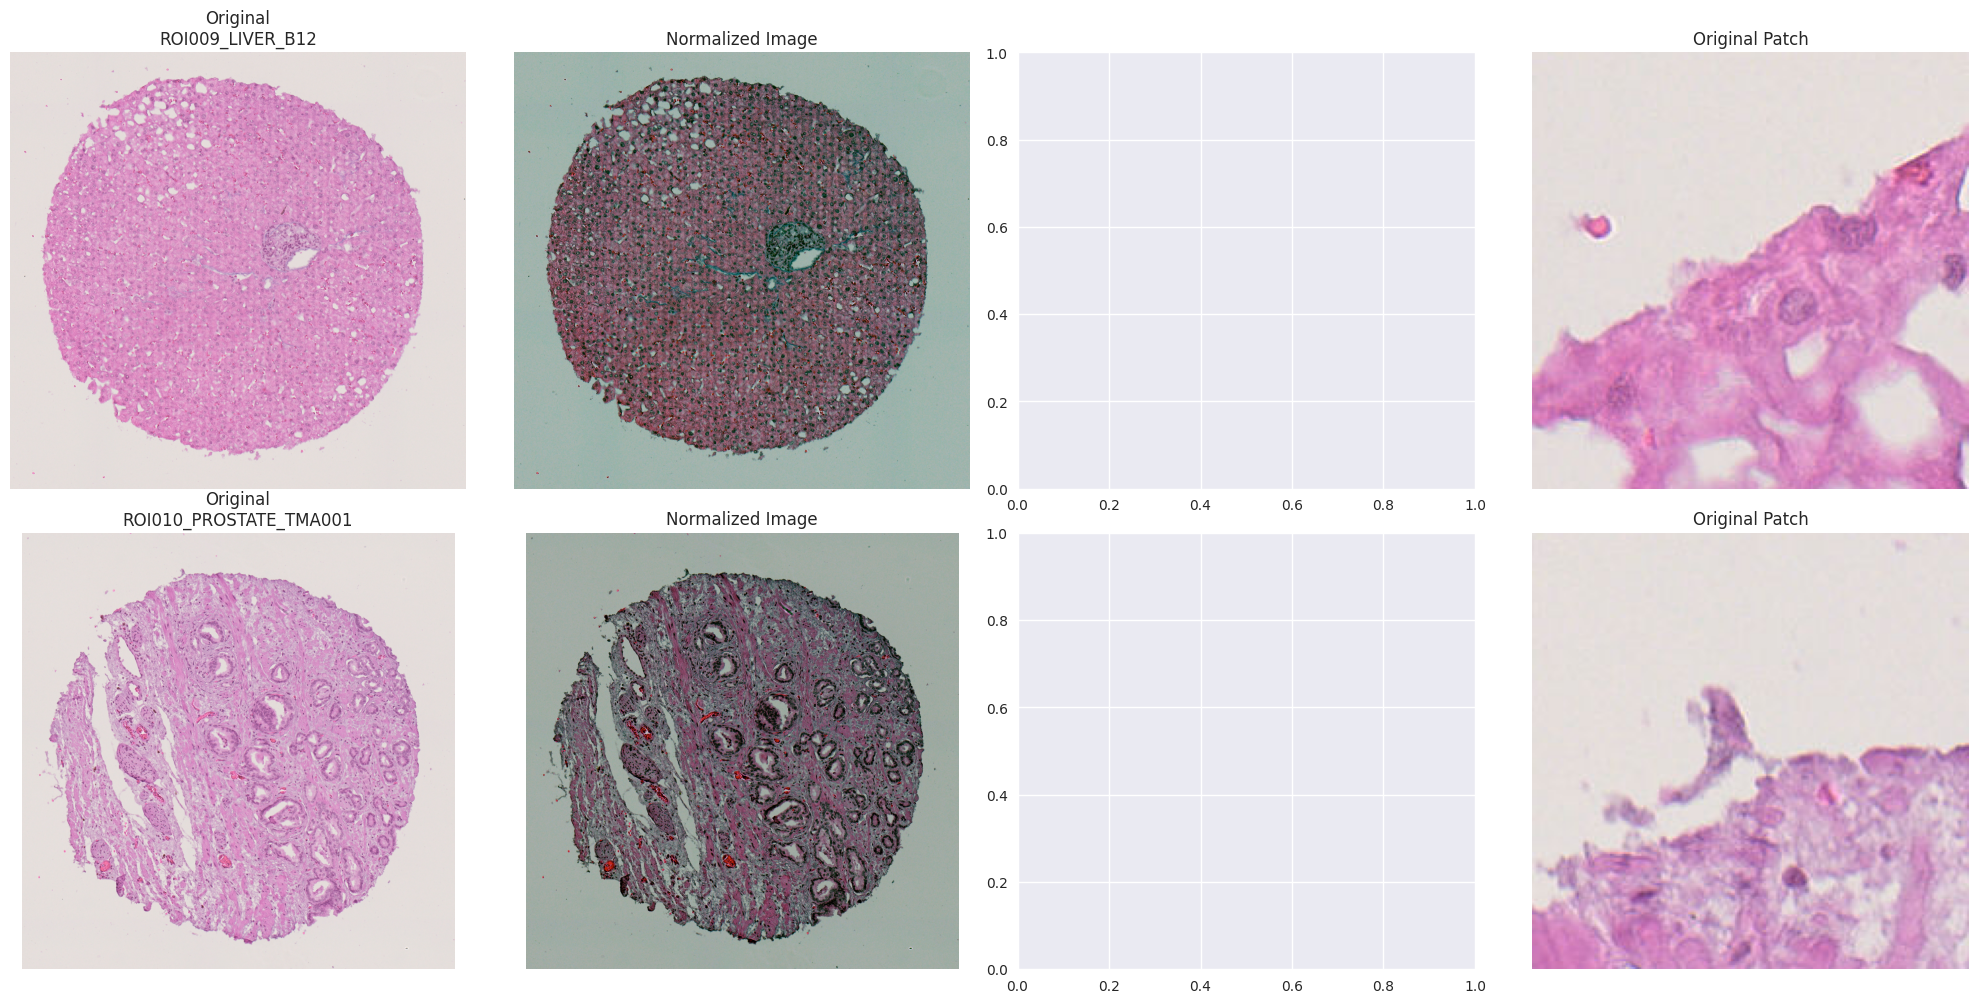

Applying stain normalization
 Processing 55 images with known labels:
   • liver: 1 images
   • malignant: 48 images
   • benign: 5 images
   • kidney: 1 images


Processing images:   0%|          | 0/55 [00:00<?, ?it/s]

 ROI009_LIVER_B12: 30 patches (liver)
 ROI010_PROSTATE_TMA001: 30 patches (malignant)
 ROI011_PROSTATE_TMA002: 30 patches (malignant)
 ROI012_PROSTATE_TMA003: 30 patches (malignant)
 ROI013_PROSTATE_TMA004: 30 patches (malignant)
 ROI014_PROSTATE_TMA005: 30 patches (malignant)
 ROI015_PROSTATE_TMA006: 30 patches (malignant)
 ROI016_PROSTATE_TMA007: 30 patches (malignant)
 ROI017_PROSTATE_TMA008: 30 patches (malignant)
 ROI018_PROSTATE_TMA009: 30 patches (malignant)
 ROI019_PROSTATE_Benign_TMA008N: 30 patches (benign)
 ROI020_PROSTATE_Benign_TMA011N: 30 patches (benign)
 ROI021_PROSTATE_TMA012: 30 patches (malignant)
 ROI022_PROSTATE_TMA013: 30 patches (malignant)
 ROI023_PROSTATE_TMA015: 30 patches (malignant)
 ROI024_PROSTATE_TMA016: 30 patches (malignant)
 ROI025_PROSTATE_TMA017: 30 patches (malignant)
 ROI026_PROSTATE_TMA018: 30 patches (malignant)
 ROI027_PROSTATE_TMA019: 30 patches (malignant)
 ROI028_PROSTATE_TMA020: 30 patches (malignant)
 ROI029_PROSTATE_TMA022: 30 patches (mal

In [70]:


def simple_color_normalize(image):
    """
    Simple color normalization - just standardize each channel
    Dont know the appropriate params for Reinhard
    """
    # Convert to float
    img_float = image.astype(np.float32)
    
    # Normalize each RGB channel separately
    for i in range(3):
        channel = img_float[:, :, i]
        # Standardize: mean=128, std=50 (reasonable for H&E)
        channel_norm = (channel -channel.mean()) / (channel.std() + 1e-6) * 50 + 128
        img_float[:, :, i] = np.clip(channel_norm, 0, 255)
    
    return img_float.astype(np.uint8)



def extract_patches_from_tissue(image, patch_size=224, overlap=0.3, normalize_stain=True,):
    """
    Extract patches only from tissue regions (not background)
    """

    if normalize_stain:
        simple_color_normalize(image)
        
           
    h, w = image.shape[:2]
    stride = int(patch_size * (1 - overlap))
    patches = []
    coordinates = []
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            # Simple tissue detection: avoid gray background
            gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY) if len(patch.shape) == 3 else patch
            
            # Calculate how much of the patch is background (gray/white)
            background_pixels = np.sum((gray > 200) | (gray < 50))  # Very bright or very dark
            background_ratio = background_pixels / (patch_size ** 2)
            
            # Only keep patches that are mostly tissue (not background)
            if background_ratio < 0.7:  # Less than 70% background
                patches.append(patch)
                coordinates.append((x, y))
    
    return patches, coordinates

def preprocess_all_images(dataset_df, patch_size=224, overlap=0.3, max_patches_per_image=30, 
                         normalize_stain=True,):
  
    if normalize_stain:
        print(f"Applying stain normalization")
    else:
        print(" No stain normalization")
    
    all_patches = []
    all_labels = []
    all_metadata = []
    
    # Only process images with known labels
    valid_df = dataset_df[~dataset_df['cancer_status'].isin(['unknown'])].copy()
    
    print(f" Processing {len(valid_df)} images with known labels:")
    for status in valid_df['cancer_status'].unique():
        count = len(valid_df[valid_df['cancer_status'] == status])
        print(f"   • {status}: {count} images")
    
    for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df), desc="Processing images"):
        # Load image
        img_array = load_one_image(row['he_image_path'])
        
        if img_array is not None:
            # Extract patches with stain normalization
            patches, coords = extract_patches_from_tissue(
                img_array, patch_size, overlap, normalize_stain, 
            )
            
            # Limit patches per image
            if len(patches) > max_patches_per_image:
                indices = np.random.choice(len(patches), max_patches_per_image, replace=False)
                patches = [patches[i] for i in indices]
                coords = [coords[i] for i in indices]
            
            # Store patches and labels
            for patch, coord in zip(patches, coords):
                all_patches.append(patch)
                all_labels.append(row['cancer_status'])
                all_metadata.append({
                    'roi_folder': row['roi_folder'],
                    'tissue_type': row['tissue_type'],
                    'coordinate': coord,
                    'source_image': row['he_image_path'],
                    'normalized': normalize_stain,
                })
            
            print(f" {row['roi_folder']}: {len(patches)} patches ({row['cancer_status']})")
        else:
            print(f" Failed to load: {row['roi_folder']}")
    
    print(f"\n PREPROCESSING COMPLETE!")
    print(f" Total patches extracted: {len(all_patches)}")
    
    # Show label distribution
    label_counts = Counter(all_labels)
    print(f"🏷️ Label distribution:")
    for label, count in label_counts.items():
        print(f"   • {label}: {count} patches")
    
    return all_patches, all_labels, all_metadata

def compare_normalization_methods(dataset_df, n_samples=3):
    """
    Compare original vs normalized images
    """
    print("COMPARING STAIN NORMALIZATION METHODS")
    print("=" * 50)
    
    # Get sample images
    sample_rows = dataset_df.head(n_samples)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img = load_one_image(row['he_image_path'])
        if img is not None:
            # Original
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"Original\n{row['roi_folder']}")
            axes[i, 0].axis('off')
            
            # Normalized imafg
            normal_img = simple_color_normalize(img)
            axes[i, 1].imshow(normal_img)
            axes[i, 1].set_title("Normalized Image")
            axes[i, 1].axis('off')
            
           
            
            # Show a patch comparison
            patches_orig, _ = extract_patches_from_tissue(img, normalize_stain=False)
            if len(patches_orig) > 0:
                axes[i, 3].imshow(patches_orig[0])
                axes[i, 3].set_title("Original Patch")
                axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run comparison first
if dataset_df is not None and len(dataset_df) > 0:
   
    compare_normalization_methods(dataset_df, n_samples=2)
    
    # Run preprocessing with stain normalization
    patches, labels, metadata = preprocess_all_images(
        dataset_df, 
        patch_size=224, 
        overlap=0.3, 
        max_patches_per_image=30,
        normalize_stain=True,  # Enable stain normalization
      
    )
    
    if len(patches) > 0:
        print(f"\n📏 Sample patch shape: {patches[0].shape}")
        print(" Preprocessing with stain normalization complete!")
    else:
        print(" No patches extracted!")
else:
    print(" No dataset available!")

📊 Pixel Intensity Distribution:
Mean: 185.2
Median: 194.0
Std: 35.2
Range: 4 - 255


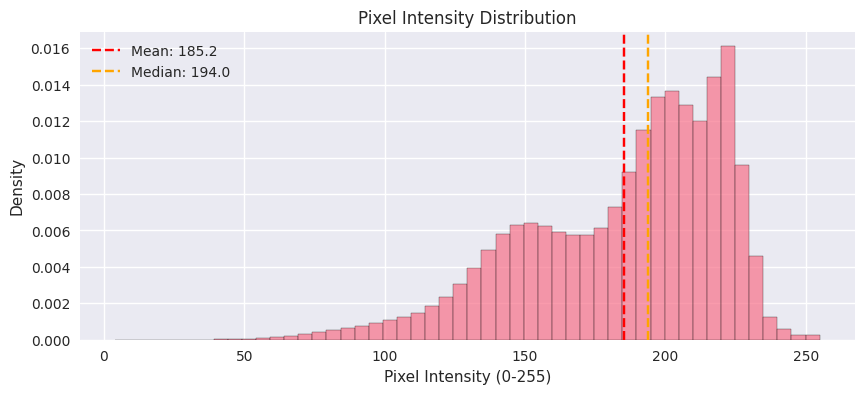

In [71]:
# Analyze pixel intensity distribution across all patches
all_pixel_values = []
for patch in patches[:100]:  # Sample first 100 patches to avoid memory issues
    all_pixel_values.extend(patch.flatten())

all_pixel_values = np.array(all_pixel_values)

print(f"📊 Pixel Intensity Distribution:")
print(f"Mean: {all_pixel_values.mean():.1f}")
print(f"Median: {np.median(all_pixel_values):.1f}")
print(f"Std: {all_pixel_values.std():.1f}")
print(f"Range: {all_pixel_values.min()} - {all_pixel_values.max()}")

# Plot continuous distribution
plt.figure(figsize=(10, 4))
plt.hist(all_pixel_values, bins=50, alpha=0.7, density=True, edgecolor='black')
plt.axvline(all_pixel_values.mean(), color='red', linestyle='--', label=f'Mean: {all_pixel_values.mean():.1f}')
plt.axvline(np.median(all_pixel_values), color='orange', linestyle='--', label=f'Median: {np.median(all_pixel_values):.1f}')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Density')
plt.title('Pixel Intensity Distribution')
plt.legend()
plt.show()

📊 RGB Channel Statistics:
Red   - Mean: 208.4, Median: 213.0
Green - Mean: 153.9, Median: 151.0
Blue  - Mean: 193.2, Median: 196.0


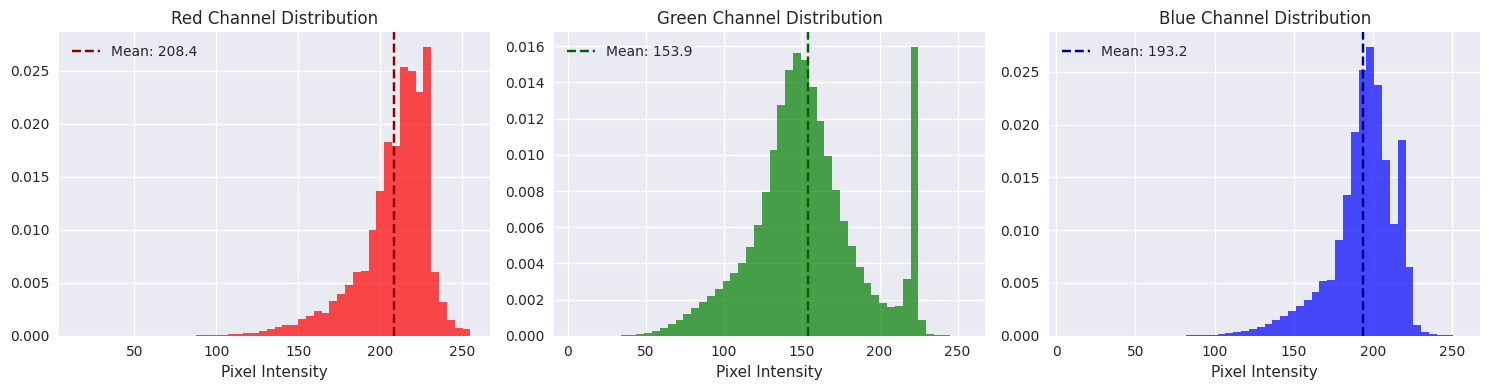

In [72]:
# Analyze RGB channels separately
red_values = []
green_values = []
blue_values = []

for patch in patches[:100]:  # Sample first 100 patches
    red_values.extend(patch[:,:,0].flatten())    # Red channel
    green_values.extend(patch[:,:,1].flatten())  # Green channel  
    blue_values.extend(patch[:,:,2].flatten())   # Blue channel

# Convert to numpy arrays
red_values = np.array(red_values)
green_values = np.array(green_values)  
blue_values = np.array(blue_values)

print(f"📊 RGB Channel Statistics:")
print(f"Red   - Mean: {red_values.mean():.1f}, Median: {np.median(red_values):.1f}")
print(f"Green - Mean: {green_values.mean():.1f}, Median: {np.median(green_values):.1f}")
print(f"Blue  - Mean: {blue_values.mean():.1f}, Median: {np.median(blue_values):.1f}")

# Plot each channel
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(red_values, bins=50, alpha=0.7, color='red', density=True)
plt.axvline(red_values.mean(), color='darkred', linestyle='--', label=f'Mean: {red_values.mean():.1f}')
plt.title('Red Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(green_values, bins=50, alpha=0.7, color='green', density=True)
plt.axvline(green_values.mean(), color='darkgreen', linestyle='--', label=f'Mean: {green_values.mean():.1f}')
plt.title('Green Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(blue_values, bins=50, alpha=0.7, color='blue', density=True)
plt.axvline(blue_values.mean(), color='darkblue', linestyle='--', label=f'Mean: {blue_values.mean():.1f}')
plt.title('Blue Channel Distribution')
plt.xlabel('Pixel Intensity')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
def create_train_val_split(patches, labels, test_size=0.2, val_size=0.2):
   
    
    # Create label mapping
    unique_labels = sorted(list(set(labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for label, idx in enumerate(unique_labels)}
    idx_to_label = {0: 'benign', 1: 'kidney', 2: 'liver', 3: 'malignant'}
    
    # Convert labels to numbers
    numeric_labels = [label_to_idx[label] for label in labels]
    
    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        patches, numeric_labels, test_size=test_size, 
        stratify=numeric_labels, random_state=42
    )
    
    # Second split: train vs val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), 
        stratify=y_temp, random_state=42
    )
    
    print(f"Data split:")
    print(f"   • Training:   {len(X_train)} patches")
    print(f"   • Validation: {len(X_val)} patches") 
    print(f"   • Test:       {len(X_test)} patches")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_to_idx, idx_to_label

# Call the function and unpack the results
X_train, X_val, X_test, y_train, y_val, y_test, label_to_idx, idx_to_label = create_train_val_split(patches, labels)

Data split:
   • Training:   990 patches
   • Validation: 330 patches
   • Test:       330 patches


In [74]:
class HEPatchDataset(Dataset):
    def __init__(self, patches, labels, transform=None):
        self.patches = patches
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        label = self.labels[idx]
        
        # Convert to PIL for transforms
        if isinstance(patch, np.ndarray):
            patch = Image.fromarray(patch.astype(np.uint8))
        
        if self.transform:
            patch = self.transform(patch)
        
        return patch, torch.tensor(label, dtype=torch.long)

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = HEPatchDataset(X_train, y_train, transform=train_transform)
val_dataset = HEPatchDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f" Created DataLoaders:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches: {len(val_loader)}")

 Created DataLoaders:
   • Train batches: 31
   • Val batches: 11


In [75]:
class CancerClassifier(nn.Module):
    def __init__(self, num_classes):
        
        super(CancerClassifier,self).__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc=nn.Linear(self.backbone.fc.in_features,num_classes)

    def forward(self,x):
        return self.backbone(x)

num_classes=len(label_to_idx)

model=CancerClassifier(num_classes)



In [76]:
def train_cancer_model(model, train_loader, val_loader, epochs=30, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  # ← Fixed: was 'loss'
    optimizer = optim.Adam(model.parameters(), lr=lr)  # ← Fixed: was 'paramaters()' and 'lr()'
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0
    
    print(f"🔥 Training on: {device}")
    print(f"📊 Classes: {list(idx_to_label.values())}")
    print(f"📈 Epochs: {epochs}, Learning Rate: {lr}")
    print("-" * 50)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        print(f"Epoch [{epoch+1}/{epochs}]")

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc="Training")):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()  # ← Fixed: was 'optimzer'
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()  # ← Fixed: was 'optimzer'

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0  # ← Fixed: was 'val_corect'
        val_total = 0

        with torch.no_grad():
            for data, targets in tqdm(val_loader, desc="Validation"):
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_cancer_model.pth')
            print(f"✅ New best model saved! Val Accuracy: {val_accuracy:.4f}")
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)
    
    print(f"🎉 Training Complete!")
    print(f"🏆 Best Validation Accuracy: {best_val_accuracy:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses, 
        'val_accuracies': val_accuracies,
        'best_accuracy': best_val_accuracy
    }

history = train_cancer_model(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader,
    epochs=40,
    lr=0.001
)

🔥 Training on: cuda
📊 Classes: ['benign', 'kidney', 'liver', 'malignant']
📈 Epochs: 40, Learning Rate: 0.001
--------------------------------------------------
Epoch [1/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.8727
Train Loss: 0.6589 | Train Acc: 0.8162
Val Loss: 2.3125 | Val Acc: 0.8727
Learning Rate: 0.001000
--------------------------------------------------
Epoch [2/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.4486 | Train Acc: 0.8727
Val Loss: 0.4099 | Val Acc: 0.8667
Learning Rate: 0.001000
--------------------------------------------------
Epoch [3/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.8848
Train Loss: 0.4009 | Train Acc: 0.8697
Val Loss: 0.5045 | Val Acc: 0.8848
Learning Rate: 0.001000
--------------------------------------------------
Epoch [4/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.8970
Train Loss: 0.4111 | Train Acc: 0.8677
Val Loss: 0.4757 | Val Acc: 0.8970
Learning Rate: 0.001000
--------------------------------------------------
Epoch [5/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3880 | Train Acc: 0.8778
Val Loss: 0.3975 | Val Acc: 0.8879
Learning Rate: 0.001000
--------------------------------------------------
Epoch [6/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3406 | Train Acc: 0.8818
Val Loss: 0.8129 | Val Acc: 0.5939
Learning Rate: 0.001000
--------------------------------------------------
Epoch [7/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3534 | Train Acc: 0.8768
Val Loss: 0.4679 | Val Acc: 0.8394
Learning Rate: 0.001000
--------------------------------------------------
Epoch [8/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3280 | Train Acc: 0.8919
Val Loss: 0.3229 | Val Acc: 0.8909
Learning Rate: 0.001000
--------------------------------------------------
Epoch [9/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.2985 | Train Acc: 0.8899
Val Loss: 0.5055 | Val Acc: 0.8364
Learning Rate: 0.001000
--------------------------------------------------
Epoch [10/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3084 | Train Acc: 0.8848
Val Loss: 0.5275 | Val Acc: 0.8273
Learning Rate: 0.001000
--------------------------------------------------
Epoch [11/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.3029 | Train Acc: 0.8808
Val Loss: 0.3067 | Val Acc: 0.8848
Learning Rate: 0.001000
--------------------------------------------------
Epoch [12/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9030
Train Loss: 0.2823 | Train Acc: 0.8879
Val Loss: 0.2868 | Val Acc: 0.9030
Learning Rate: 0.001000
--------------------------------------------------
Epoch [13/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.2961 | Train Acc: 0.8869
Val Loss: 0.4007 | Val Acc: 0.8364
Learning Rate: 0.001000
--------------------------------------------------
Epoch [14/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9061
Train Loss: 0.2685 | Train Acc: 0.8970
Val Loss: 0.2448 | Val Acc: 0.9061
Learning Rate: 0.001000
--------------------------------------------------
Epoch [15/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.2449 | Train Acc: 0.9020
Val Loss: 0.2809 | Val Acc: 0.8788
Learning Rate: 0.001000
--------------------------------------------------
Epoch [16/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.2462 | Train Acc: 0.9071
Val Loss: 0.2700 | Val Acc: 0.8848
Learning Rate: 0.001000
--------------------------------------------------
Epoch [17/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.2142 | Train Acc: 0.9182
Val Loss: 0.4594 | Val Acc: 0.8242
Learning Rate: 0.001000
--------------------------------------------------
Epoch [18/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9091
Train Loss: 0.2363 | Train Acc: 0.9121
Val Loss: 0.2840 | Val Acc: 0.9091
Learning Rate: 0.000500
--------------------------------------------------
Epoch [19/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1844 | Train Acc: 0.9182
Val Loss: 0.2367 | Val Acc: 0.8939
Learning Rate: 0.000500
--------------------------------------------------
Epoch [20/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1734 | Train Acc: 0.9273
Val Loss: 0.2406 | Val Acc: 0.8939
Learning Rate: 0.000500
--------------------------------------------------
Epoch [21/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9182
Train Loss: 0.1731 | Train Acc: 0.9253
Val Loss: 0.1995 | Val Acc: 0.9182
Learning Rate: 0.000500
--------------------------------------------------
Epoch [22/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1678 | Train Acc: 0.9333
Val Loss: 0.2636 | Val Acc: 0.9000
Learning Rate: 0.000500
--------------------------------------------------
Epoch [23/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1583 | Train Acc: 0.9364
Val Loss: 0.2949 | Val Acc: 0.8697
Learning Rate: 0.000500
--------------------------------------------------
Epoch [24/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1416 | Train Acc: 0.9515
Val Loss: 0.3459 | Val Acc: 0.9121
Learning Rate: 0.000500
--------------------------------------------------
Epoch [25/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1623 | Train Acc: 0.9273
Val Loss: 0.2847 | Val Acc: 0.8879
Learning Rate: 0.000250
--------------------------------------------------
Epoch [26/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9364
Train Loss: 0.1451 | Train Acc: 0.9333
Val Loss: 0.1749 | Val Acc: 0.9364
Learning Rate: 0.000250
--------------------------------------------------
Epoch [27/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1040 | Train Acc: 0.9525
Val Loss: 0.1646 | Val Acc: 0.9303
Learning Rate: 0.000250
--------------------------------------------------
Epoch [28/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1147 | Train Acc: 0.9606
Val Loss: 0.1965 | Val Acc: 0.9303
Learning Rate: 0.000250
--------------------------------------------------
Epoch [29/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9424
Train Loss: 0.0929 | Train Acc: 0.9606
Val Loss: 0.1297 | Val Acc: 0.9424
Learning Rate: 0.000250
--------------------------------------------------
Epoch [30/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0935 | Train Acc: 0.9707
Val Loss: 0.1895 | Val Acc: 0.9273
Learning Rate: 0.000250
--------------------------------------------------
Epoch [31/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1016 | Train Acc: 0.9586
Val Loss: 0.2662 | Val Acc: 0.9182
Learning Rate: 0.000250
--------------------------------------------------
Epoch [32/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1022 | Train Acc: 0.9596
Val Loss: 0.2026 | Val Acc: 0.9303
Learning Rate: 0.000250
--------------------------------------------------
Epoch [33/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

✅ New best model saved! Val Accuracy: 0.9485
Train Loss: 0.1015 | Train Acc: 0.9616
Val Loss: 0.1221 | Val Acc: 0.9485
Learning Rate: 0.000250
--------------------------------------------------
Epoch [34/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0982 | Train Acc: 0.9616
Val Loss: 0.1493 | Val Acc: 0.9364
Learning Rate: 0.000250
--------------------------------------------------
Epoch [35/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0802 | Train Acc: 0.9707
Val Loss: 0.1328 | Val Acc: 0.9485
Learning Rate: 0.000250
--------------------------------------------------
Epoch [36/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0820 | Train Acc: 0.9657
Val Loss: 0.1704 | Val Acc: 0.9091
Learning Rate: 0.000250
--------------------------------------------------
Epoch [37/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0728 | Train Acc: 0.9737
Val Loss: 0.2194 | Val Acc: 0.9212
Learning Rate: 0.000125
--------------------------------------------------
Epoch [38/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0794 | Train Acc: 0.9727
Val Loss: 0.1468 | Val Acc: 0.9364
Learning Rate: 0.000125
--------------------------------------------------
Epoch [39/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0775 | Train Acc: 0.9737
Val Loss: 0.1410 | Val Acc: 0.9394
Learning Rate: 0.000125
--------------------------------------------------
Epoch [40/40]


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0738 | Train Acc: 0.9677
Val Loss: 0.1631 | Val Acc: 0.9455
Learning Rate: 0.000125
--------------------------------------------------
🎉 Training Complete!
🏆 Best Validation Accuracy: 0.9485


Test Accuracy: 0.9364
Test Loss: 0.2013


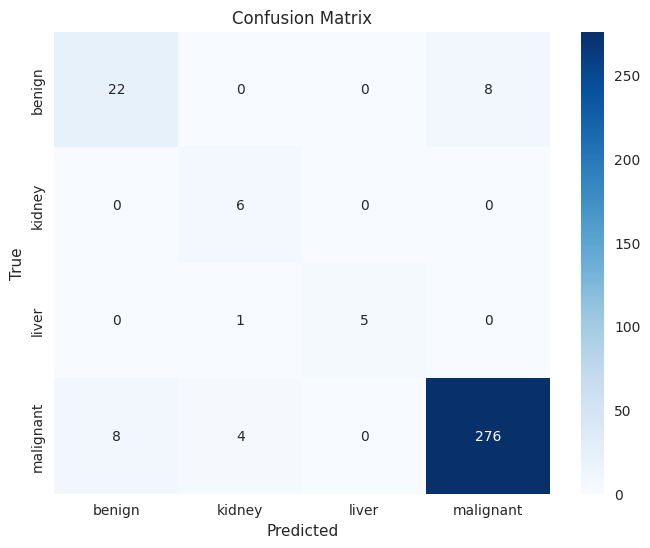

📈 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      benign       0.73      0.73      0.73        30
      kidney       0.55      1.00      0.71         6
       liver       1.00      0.83      0.91         6
   malignant       0.97      0.96      0.97       288

    accuracy                           0.94       330
   macro avg       0.81      0.88      0.83       330
weighted avg       0.94      0.94      0.94       330



In [77]:
# Modified evaluate_model function that returns predictions

def evaluate_model_with_predictions(model, X_test, y_test):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Create test dataset and loader
    test_dataset = HEPatchDataset(X_test, y_test, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    all_predictions = []
    all_true_labels = []
    total_loss = 0
    correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            
            predictions = torch.argmax(outputs, dim=1)
            
            # Store predictions and true labels
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(target.cpu().numpy())
            
            total_loss += loss.item()
            correct += predictions.eq(target).sum().item()
    
    accuracy = correct / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {avg_loss:.4f}")
    
    return accuracy, avg_loss, all_predictions, all_true_labels

# Evaluation functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, idx_to_label):
    class_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return cm

def get_per_class_metrics(y_true, y_pred, idx_to_label):
    class_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    
    print("📈 DETAILED CLASSIFICATION REPORT:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names))

# RUN THE COMPLETE EVALUATION
accuracy, loss, y_pred, y_true = evaluate_model_with_predictions(model, X_test, y_test)

# Plot confusion matrix
cm = plot_confusion_matrix(y_true, y_pred, idx_to_label)

# Show detailed metrics
get_per_class_metrics(y_true, y_pred, idx_to_label)

🔍 TRAINING ANALYSIS:
📊 Best Validation Loss: 0.1221 at Epoch 33
🎯 Best Validation Accuracy: 94.85% at Epoch 33

📈 Recent Trends (last 5 epochs):
   • Training Loss: 📉 Decreasing
   • Validation Loss: 📉 Decreasing

💡 RECOMMENDATIONS:
   • 📈 Model still improving - consider training longer
   • Monitor for overfitting in extended training


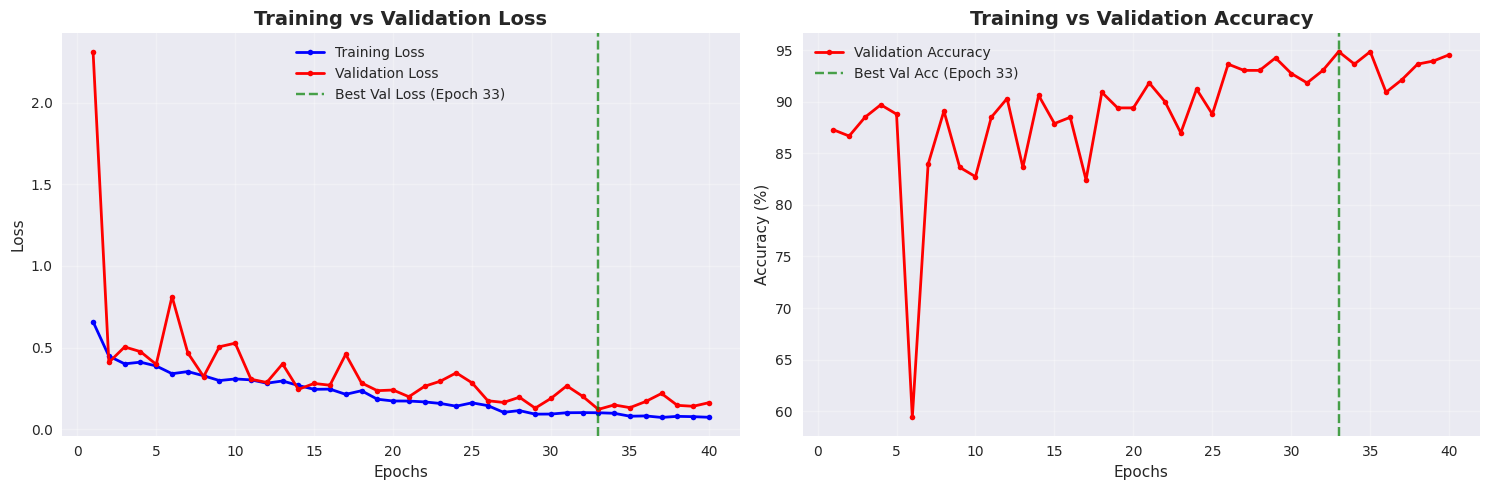

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(history, save_path='training_curves.png'):
    """
    Plot training curves to analyze overfitting and determine optimal stopping point
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Plot 1: Loss curves
    axes[0].plot(epochs, history['train_losses'], 'b-o', label='Training Loss', linewidth=2, markersize=4)
    axes[0].plot(epochs, history['val_losses'], 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Find best epoch (lowest val loss)
    best_epoch = np.argmin(history['val_losses']) + 1
    best_val_loss = min(history['val_losses'])
    axes[0].axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Val Loss (Epoch {best_epoch})')
    axes[0].legend()
    
    # Plot 2: Accuracy curves
    # Convert to percentages if not already
    train_acc = [acc * 100 if acc <= 1 else acc for acc in history.get('train_accuracies', [])]
    val_acc = [acc * 100 if acc <= 1 else acc for acc in history['val_accuracies']]
    
    if train_acc:  # If you have training accuracy
        axes[1].plot(epochs, train_acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    axes[1].plot(epochs, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Find best accuracy epoch
    best_acc_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    axes[1].axvline(x=best_acc_epoch, color='green', linestyle='--', alpha=0.7, 
                   label=f'Best Val Acc (Epoch {best_acc_epoch})')
    axes[1].legend()
    
    plt.tight_layout()
    
    # Analysis text
    print("🔍 TRAINING ANALYSIS:")
    print("=" * 50)
    print(f"📊 Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}")
    print(f"🎯 Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_acc_epoch}")
    
    # Overfitting detection - FIXED
    if len(history['val_losses']) > 3:
        final_val_loss = history['val_losses'][-1]
        final_train_loss = history['train_losses'][-1]
        
        # Check if validation loss is increasing while training loss decreases
        # FIX: Get last 5 values correctly
        last_5_val = history['val_losses'][-5:]  # Get last 5 values
        last_5_train = history['train_losses'][-5:]  # Get last 5 values
        
        val_trend = np.polyfit(range(len(last_5_val)), last_5_val, 1)[0]
        train_trend = np.polyfit(range(len(last_5_train)), last_5_train, 1)[0]
        
        print(f"\n📈 Recent Trends (last {len(last_5_val)} epochs):")
        print(f"   • Training Loss: {'📉 Decreasing' if train_trend < 0 else '📈 Increasing'}")
        print(f"   • Validation Loss: {'📉 Decreasing' if val_trend < 0 else '📈 Increasing'}")
        
        # Overfitting warning
        if train_trend < -0.01 and val_trend > 0.01:
            print(f"\n  POTENTIAL OVERFITTING DETECTED!")
            print(f"   • Training loss decreasing but validation loss increasing")
            print(f"   • Consider stopping around epoch {best_epoch}")
        
        # Gap analysis
        loss_gap = final_val_loss - final_train_loss
        if loss_gap > 0.5:
            print(f"\n  LARGE TRAIN-VAL GAP: {loss_gap:.3f}")
            print(f"   • Model may be overfitting")
            print(f"   • Consider: more regularization, dropout, or early stopping")
    
   
    print(f"\n RECOMMENDATIONS:")
    if best_epoch < len(epochs) * 0.7:
        print(f"   •  Early stopping recommended around epoch {best_epoch}")
        print(f"   • Model achieved best performance early in training")
    else:
        print(f"   • 📈 Model still improving - consider training longer")
        print(f"   • Monitor for overfitting in extended training")
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_epoch, best_val_acc

# Now this should work!
best_epoch, best_accuracy = plot_training_curves(history)

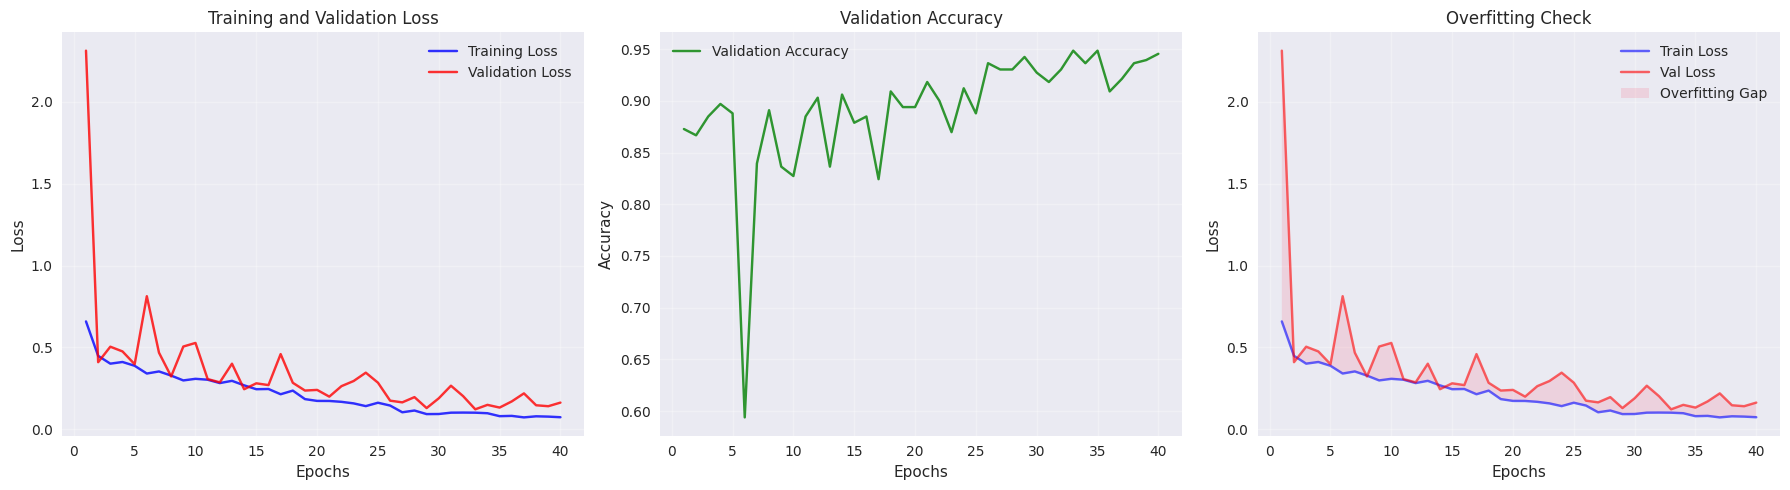

📊 TRAINING SUMMARY:
   • Final Train Loss: 0.0738
   • Final Val Loss: 0.1631
   • Best Val Accuracy: 0.9485
   • Final Val Accuracy: 0.9455


In [79]:
def plot_training_results(history):
    """
    Plot training curves to see how well the model learned
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Plot 1: Loss curves
    axes[0].plot(epochs, history['train_losses'], 'b-', label='Training Loss', alpha=0.8)
    axes[0].plot(epochs, history['val_losses'], 'r-', label='Validation Loss', alpha=0.8)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy curve
    axes[1].plot(epochs, history['val_accuracies'], 'g-', label='Validation Accuracy', alpha=0.8)
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Learning behavior
    axes[2].plot(epochs, history['train_losses'], 'b-', alpha=0.6, label='Train Loss')
    axes[2].plot(epochs, history['val_losses'], 'r-', alpha=0.6, label='Val Loss')
    axes[2].fill_between(epochs, history['train_losses'], history['val_losses'], 
                        alpha=0.2, label='Overfitting Gap')
    axes[2].set_title('Overfitting Check')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final stats
    print(f"📊 TRAINING SUMMARY:")
    print(f"   • Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"   • Final Val Loss: {history['val_losses'][-1]:.4f}")
    print(f"   • Best Val Accuracy: {history['best_accuracy']:.4f}")
    print(f"   • Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")

# Run this after training completes
if 'history' in locals():
    plot_training_results(history)

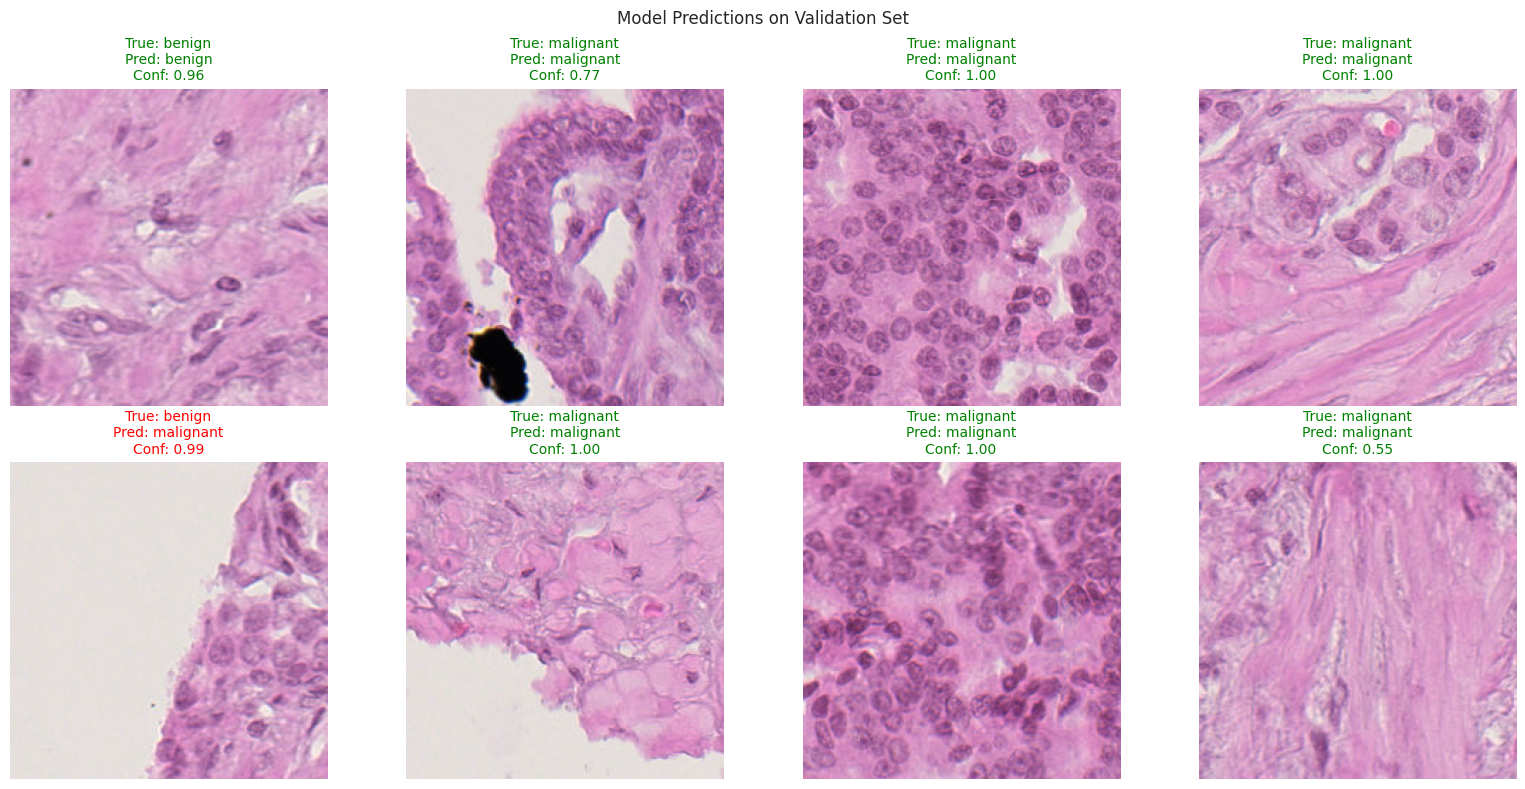

In [80]:
def test_model_predictions(model, val_loader, idx_to_label, num_samples=8):
    """
    Test the model and show some predictions
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    # Get one batch for testing
    data_iter = iter(val_loader)
    data, targets = next(data_iter)
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Show results
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(min(num_samples, len(data))):
        row = i // 4
        col = i % 4
        
        # Denormalize image for display
        img = data[i].cpu().permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)
        
        axes[row, col].imshow(img)
        
        # Get prediction info
        true_label = idx_to_label[targets[i].item()]
        pred_label = idx_to_label[predicted[i].item()]
        confidence = probabilities[i][predicted[i]].item()
        
        # Color code: green if correct, red if wrong
        color = 'green' if predicted[i] == targets[i] else 'red'
        
        axes[row, col].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
                                color=color, fontsize=10)
        axes[row, col].axis('off')
    
    plt.suptitle("Model Predictions on Validation Set")
    plt.tight_layout()
    plt.show()

# Test your model
if 'model' in locals() and 'val_loader' in locals():
    test_model_predictions(model, val_loader, idx_to_label)